<a href="https://colab.research.google.com/github/licciard/fun-stuff/blob/main/math/goldbach2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The strategy here is to use Bertrand's proof on the right side of the inequality but with a stricter p^R for p > sqrt(2n) and on the left side use the polynomial approximation

In [ ]:
import sympy
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as scp
import scipy.optimize as opt
import random 

ps = np.array([i for i in sympy.sieve.primerange(3, 10**6)])
print(ps)

import mpmath
print(mpmath.li(100))

%matplotlib inline

[     3      5      7 ... 999961 999979 999983]
30.1261415840796


### Actual values of the multiplication

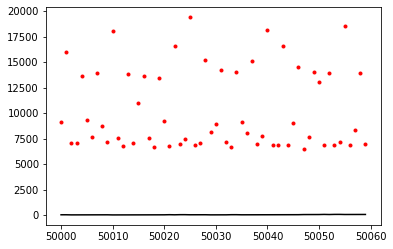

[[ 1.         -0.06295076]
 [-0.06295076  1.        ]]


In [ ]:
# function: log(2n x (2n - 1) x ... x (n+1)) = log(2n)+log(2n-1)+...+log(n+1)
def log_sum_all(n):
  values = np.array(range(n+1,2*n+1))
  #print(values)
  return np.sum(np.log(values))
# print(log_sum_all(10))

# function: log(mult primes in (n,2n)) = log(p_k+1) + ... + log(p_K)
def log_sum_newprimes(n):
  values = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  #print(values, np.log(values))
  return np.sum(np.log(values))
#print(log_sum_newprimes(15))

# function: log(mult 2n - primes in (3,n)) = log(2n-3) + log(2n-5) + ... + log(2n-p_k)
def log_sum_oldprimes(n):
  primes = np.array([i for i in sympy.sieve.primerange(3, n)])
  values = 2*n - primes
  #print(primes, values, np.log(values))
  return np.sum(np.log(values))
#print(log_sum_oldprimes(15))

# function: log(n!) = log(n)+...+log(1)
def log_factorial(n):
  values = np.array(range(1,n+1))
  #print(values, np.log(values))
  return np.sum(np.log(values))
# print(log_factorial(10))

# actual multiplication without new primes in (n,2n)
def log_sum_nonewprimes(n):
  allnumbers = np.array(range(n+1,2*n+1))
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  values = np.array(np.setdiff1d(allnumbers,newprimes))
  #print(values,np.log(values))
  return np.sum(np.log(values))- n*np.log(n) - 2*n*(np.log(2)-1)
#print(log_sum_nonewprimes(15))

# if we assume oldprimes must be in multiplication above
def log_sum_forceoldprimes(n):
  allnumbers = np.array(range(n+1,2*n+1))
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  no_newprime_values = np.array(np.setdiff1d(allnumbers,newprimes))
  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n)])
  oldprime_values = 2*n - oldprimes
  values = np.union1d(no_newprime_values,oldprime_values)
  #print("values: {}".format(values))
  #print(newprimes,oldprimes,oldprime_values,values,np.log(values))
  return np.sum(np.log(values))- n*np.log(n) - 2*n*(np.log(2)-1)
#print(log_sum_forceoldprimes(15))

# let's compare difference between forcing old primes into multiplication
# and without new primes

xi, xf = 50000,50060 # 10**3,2000 #10**4 #10**4,2*10**4 #0  
dx = np.arange(xi,xf)
reality = np.array([log_sum_nonewprimes(x) for x in dx])
assumption = np.array([log_sum_forceoldprimes(x) for x in dx])

#plt.plot(dx, assumption-np.array([2**0.5*x/np.log(x) for x in dx]), 'r.')
plt.plot(dx, assumption, 'r.')
plt.plot(dx, reality, 'k-')
#plt.plot(dx, np.array([x/np.log(x) for x in dx]),'b-')
#plt.plot(dx, assumption-reality, 'k-')

axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([-100,2000])

plt.show()
#print(px/apx)

print(np.corrcoef(reality,assumption))

## Right side of the inequality

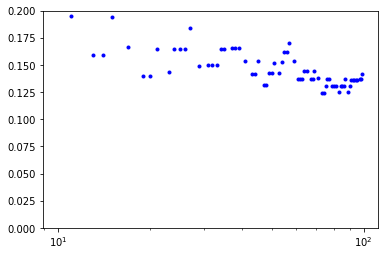

In [ ]:
# weak upper bound from Erdos like in Wikipedia
# do no forget to include the n! from denominator
def ub_wiki(n):
  twon = 2*n
  return np.sqrt(twon)*np.log(twon)+(twon/3.)*np.log(4)+log_factorial(n)-n*np.log(n)- 2*n*(np.log(2)-1)

# my first attempt to put inequality on this sum of R's
def ub_caio(n):
  twon = 2*n
  sqrt2n = np.sqrt(twon)
  myterm = twon*(np.log(2)-0.5 + 100./np.log(twon)**4) # 0.014/np.log(twon)) # 2n > 70 111 or n > 36000
  #return sqrt2n*np.log(twon)+myterm+(0.5)*np.log(n)+(1-n)
  return (sqrt2n/(np.log(sqrt2n)-1.1))*np.log(twon)+myterm+(0.5)*np.log(n)+(1-n) - twon*(np.log(2)-1) #(n+0.5)*np.log(n)+(1-n) #log_factorial(n)
  #return sympy.primepi(sqrt2n)*np.log(twon)+myterm+(n+0.5)*np.log(n)+(1-n) #log_factorial(n)

def mypi(x,ub=True): # n > 230
  sign = (-1,+1)[ub]
  return mpmath.li(x)+(sign)*0.2795*(x/np.log(x)**0.75)*np.exp(-np.sqrt(np.log(x)/6.455))
  #return mpmath.li(x)+(sign)*np.sqrt(x)*np.log(x)/(8*np.pi)

def lb_primes(n):
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  newprimes = newprimes-1
  #print("new {}: {}".format(n,newprimes))
  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n+1)])
  oldprime_values = 2*n - oldprimes
  #print("old {}: {}".format(n,oldprime_values))
  allnumbers = np.array(range(n+1,2*n+1))
  #print("all {}: {}".format(n,allnumbers))
  min_numbers = np.array(np.setdiff1d(allnumbers,newprimes))
  #print("diff new {}: {}".format(n,min_numbers))
  #min_numbers = np.array(np.setdiff1d(min_numbers,oldprime_values))
  #print("used {}: {} + {}".format(n,min_numbers,oldprime_values))
  #even_numbers = np.array(range(half,n,2))
  #print("n = {}: {} = {} + {} + {}".format(n,len(min_numbers)+len(oldprime_values)+(sympy.primepi(2*n)-sympy.primepi(n)),len(min_numbers),len(oldprime_values),sympy.primepi(2*n)))
  #print("n = {}: {}+{}={}".format(n,len(min_numbers)+len(oldprime_values),sympy.primepi(2*n)-sympy.primepi(n),len(min_numbers)+len(oldprime_values)+sympy.primepi(2*n)-sympy.primepi(n)))
  #return np.sum(np.log(min_numbers)) + np.sum(np.log(oldprime_values)) - n*np.log(n) - 2*n*(np.log(2)-1)

  return np.sum(np.log(min_numbers)) - n*np.log(n) - 2*n*(np.log(2)-1)

def lb_stat(n):
  #min_numbers = np.array(random.sample(range(n+1,2*n), n-sympy.primepi(2*n)+1))

  half = int(np.floor(3*n/2 + 0.6))
  min_numbers_low = np.array(random.sample(range(n+1,half+1), (half-n)-(sympy.primepi(half)-sympy.primepi(n)+sympy.primepi(n)-sympy.primepi(half-n))))
  min_numbers_high = np.array(random.sample(range(half+1,2*n), (2*n-half)-(sympy.primepi(2*n)-sympy.primepi(half)+sympy.primepi(half-n)-sympy.primepi(2))))
  min_numbers = np.union1d(min_numbers_low,min_numbers_high)

  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n)])
  oldprime_values = 2*n - oldprimes
  #even_numbers = np.array(range(half,n,2))
  #print("n = {}: {} = {} + {} + {}".format(n,len(min_numbers)+len(oldprime_values)+(sympy.primepi(2*n)-sympy.primepi(n)),len(min_numbers),len(oldprime_values),sympy.primepi(2*n)))
  return np.sum(np.log(min_numbers)) + np.sum(np.log(oldprime_values)) - n*np.log(n) - 2*n*(np.log(2)-1)


def lb_min(n):
#  min_numbers = np.array(range(n+1,2*n))
#  half = int(3*n/2)
#  min_numbers_low = np.array(random.sample(range(n+1,half+1), (half-n)-sympy.primepi(half)+1))
#  min_numbers_high = np.array(random.sample(range(half+1,2*n), (2*n-half)-(sympy.primepi(2*n)-sympy.primepi(half))))
#  min_numbers = np.array(random.sample(range(n+1,2*n), n-sympy.primepi(2*n)))
#  min_numbers = np.array(range(n+1, 2*n - sympy.primepi(2*n)))
  ls = [int(n/4),int(2*n/4),int(3*n/4)]
  qs = [int(5*n/4),int(6*n/4),int(7*n/4)]
  min_numbers_q1 = np.array(range(n+1, qs[0]+1 - (sympy.primepi(qs[0])-sympy.primepi(ls[2])),2))
  min_numbers_q2 = np.array(range(qs[0]+1, qs[1]+1 - (sympy.primepi(qs[1])-sympy.primepi(qs[0])+sympy.primepi(ls[2])-sympy.primepi(ls[1])),2))
  min_numbers_q3 = np.array(range(qs[1]+1, qs[2]+1 - (sympy.primepi(qs[2])-sympy.primepi(qs[1])+sympy.primepi(ls[1])-sympy.primepi(ls[0])),2))
  min_numbers_q4 = np.array(range(qs[2]+1, 2*n - (sympy.primepi(2*n)-sympy.primepi(qs[2])+sympy.primepi(ls[0])-1),2))
#  min_numbers_q1 = np.array(range(n+1, qs[0]+1 - np.floor(mypi(qs[0],False))))
#  min_numbers_q2 = np.array(range(qs[0]+1, qs[1]+1 - np.floor(mypi(qs[1])-mypi(qs[0],False))))
#  min_numbers_q3 = np.array(range(qs[1]+1, qs[2]+1 - np.floor(mypi(qs[2])-mypi(qs[1],False))))
#  min_numbers_q4 = np.array(range(qs[2]+1, 2*n - np.floor(mypi(2*n)-mypi(qs[2],False))))
  min_numbers_low = np.union1d(min_numbers_q1,min_numbers_q2)
  min_numbers_high = np.union1d(min_numbers_q3,min_numbers_q4)
#  hl,hu = int(np.ceil(n/2)),int(np.ceil(3*n/2))
#  min_numbers_low = np.array(range(n+1, hu+1 - (sympy.primepi(hu)-sympy.primepi(hl))+1))
#  min_numbers_high = np.array(range(hu+1, 2*n - (sympy.primepi(2*n)-sympy.primepi(hu)+sympy.primepi(hl))))
  min_numbers = np.union1d(min_numbers_low,min_numbers_high)
  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n)])
  oldprime_values = 2*n - oldprimes
  even_numbers = np.array(range(int(n/2),n,2))
  print("n = {}: {} : {} + {} = {} + {} ".format(n,len(even_numbers)+len(min_numbers)+len(oldprime_values)+(sympy.primepi(2*n)-sympy.primepi(n)),len(min_numbers_low),len(min_numbers_high),len(min_numbers),len(oldprime_values)))
  return np.sum(np.log(even_numbers))+ np.sum(np.log(min_numbers)) + np.sum(np.log(oldprime_values)) - n*np.log(n) - 2*n*(np.log(2)-1)

xi, xf = 10,100 #450000,450100 #10**4,2*10**4 #10**4,2*10**4 #0  
dx = np.arange(xi,xf)
#dx = np.array([i*10**exp for exp in range(2, 6) for i in range(1, 10)])
#dm5, dm4, dm3, dm2, dm1, dp1, dp2,dp3,dp4,dp5 = dx-5,dx-4,dx-3,dx-2, dx-1, dx+1, dx+2,dx+3,dx+4,dx+5
#dx = np.sort(np.concatenate([dm1,dm2,dx,dp1,dp2], axis=0))
lbmin = np.array([lb_primes(x) for x in dx])
reality = np.array([log_sum_nonewprimes(x) for x in dx])
#assumption = np.array([log_sum_forceoldprimes(x) for x in dx])
#ubwiki = np.array([ub_wiki(x) for x in dx])
ubcaio = np.array([ub_caio(x) for x in dx])
#plt.plot(dx, reality, 'k.')#plt.plot(dx, np.array([1 for x in dx]), 'k-')

#plt.plot(dx, assumption, 'r.')
#plt.plot(dx, ubcaio, 'g.')
plt.plot(dx, lbmin-reality, 'b.')
#plt.plot(dx, ubcaio-lbmin, 'g.')
#plt.plot(dx, np.array([x/np.log(x) for x in dx]),'b-')
plt.xscale('log')
#plt.yscale('log')
axes = plt.gca()
axes.set_ylim([0,0.2])
plt.show()

#print(lbmin)

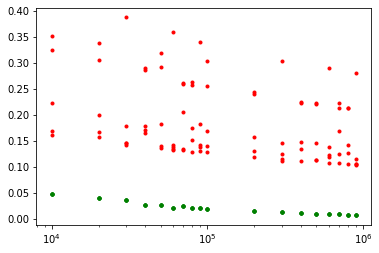

[ 478.14363071  487.07654617  486.10612279  485.13569811  484.16527212
  794.00921263  793.03110879  792.05300448  791.07489971  790.09679446
 1084.84099607 1083.85944236 1093.87997156 1092.89841733 1091.91686285
 1079.85997509 1090.16608726 1100.47222425 1099.48859167 1098.50495891
 1323.27504292 1311.47022123 1310.48515771 1309.50009407 1320.02798576
 1218.58677587 1206.59856466 1205.61243652 1204.62630829 1203.64017997
 1723.1892016  1722.2022404  1733.0646697  1720.92144355 1719.93448213
 1687.40726518 1675.1298588  1674.14222177 1685.13752002 1684.14988287
 1822.86501244 1821.87681252 1832.98931913 1832.69426073 1831.70606066
 1821.84175811 1820.85307944 1832.07046838 1831.08178962 1842.29919846
 2860.64802237 2847.45063206 2846.45930938 2845.46798669 2844.47666398
 3952.15847966 3951.16594658 3963.47809675 3962.48556364 3961.49303052
 4165.70862803 4164.71535641 4177.31445054 4176.3211789  4175.32790726
 4298.99738735 4298.00360233 4297.0098173  4296.01603227 4308.83776079
 5836.

In [ ]:
3
# make a stronger upper bound by carefully considering p^R for p > sqrt(2n)
 
# first we calculate it exactly considering
# if 2n/(d+1) < p <= 2n/d --> R=B(p)= 0 if d is even
def log_sum_primesbelow(n):
  primes = np.array([i for i in sympy.sieve.primerange(3, 2*n/3)])
  tot = 0.
  for p in primes:
    #print("Looking at p = {}".format(p))
    for d in range(3,int(2*n/3.-1)):
      #print("Question for d = {}: {} < p <= {}? {}".format(d,2.*n/(d+1),2.*n/d,(2.*n/(d+1) < p) and (p <= 2.*n/d) and (d%2==1)))
      if (2.*n/(d+1) < p) and (p <= 2.*n/d) and (d%2==1):
        tot += np.log(p)
  return tot 
#print(log_sum_primesbelow(45))

# actual exponent R in p^R that divides (2n n) in sum(R*log(p))
# function lets a range of pimes between n1 and n2
def logmult_small(n1,n2,n):
  primes = np.array([i for i in sympy.sieve.primerange(n1,n2)])
  tot = 0
  for p in primes:
    J = int((np.log(2*n)/np.log(p)))
    R = 0
    for j in range(1,J+1):
      R += (np.floor(2*n/p**j)-2*np.floor(n/p**j))
    tot += R*np.log(p)
  return tot



# strong upper bound from Erdos but using R's when it is 1 or 0 for all primes
def ub_strongest(n):
  print("Working on n = {}".format(n))
  twon = 2*n
  return np.sqrt(twon)*np.log(twon)+log_sum_primesbelow(n)+log_factorial(n)




# strongest upper bound from Erdos but using actual R's for everything including < sqrt(2n)
def ub_erdos_real(n):
  return logmult_small(1,2*n/3,n)+log_factorial(n)


#xi, xf = 1000, 20000 #65000,65050 #10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(4,6) for i in range(1, 10)])
dm5, dm4, dm3, dm2, dm1, dp1, dp2,dp3,dp4,dp5 = dx-5,dx-4,dx-3,dx-2, dx-1, dx+1, dx+2,dx+3,dx+4,dx+5
dx = np.sort(np.concatenate([dm1,dm2,dx,dp1,dp2], axis=0))
reality = np.array([log_sum_nonewprimes(x) for x in dx])
assumption = np.array([log_sum_forceoldprimes(x) for x in dx])
#ubstr = np.array([ub_strongest(x) for x in dx])
ubcaio = np.array([ub_caio(x) for x in dx])
#plt.plot(dx, reality, 'k*')
plt.plot(dx, (assumption - reality)/dx, 'r.')
#plt.plot(dx, ubstr, 'b.')
plt.plot(dx, (ubcaio - reality)/dx, 'g.')
plt.xscale('log')
#plt.yscale('log')
plt.show()

print(ubcaio-reality)

### Now to the left side....

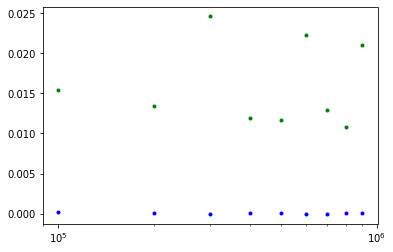

In [ ]:
# first show my approximation is good for primes as n increases

# approximation of the function for all numbers up to n
def approx_log_sum_all(n):
  roots = 2*n - np.array(range(n+1,2*n+1))
  avg = np.mean(roots)
  #print(roots)
  return len(roots)*np.log(2*n -avg)
#print(approx_log_sum_all(10))

# approximation of the function: log(mult 2n - primes in (3,n)) = log(2n-3) + log(2n-5) + ... + log(2n-p_k)
def approx_log_sum_oldprimes(n):
  primes = np.array([i for i in sympy.sieve.primerange(3, n)])
  avg = np.mean(primes)
  #print(primes, values, np.log(values))
  return len(primes)*np.log(2*n-avg)
#print(log_sum_oldprimes(15))

# approximation of the actual multiplication without new primes in (n,2n)
def approx1_log_sum_nonewprimes(n):
  allnumbers = np.array(range(n+1,2*n+1))
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  values = np.array(np.setdiff1d(allnumbers,newprimes))
  roots = 2*n - values
  avg = np.mean(roots)
  #print(values,np.log(values))
  return len(roots)*np.log(2*n - avg)
#print(log_sum_nonewprimes(15))

# if we assume oldprimes must be in multiplication above
def approx1_log_sum_forceoldprimes(n):
  allnumbers = np.array(range(n+1,2*n+1))
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  no_newprime_values = np.array(np.setdiff1d(allnumbers,newprimes))
  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n)])
  oldprime_values = 2*n - oldprimes
  values = np.union1d(no_newprime_values,oldprime_values)
  roots = 2*n-values
  avg = np.mean(roots)
  #print(newprimes,oldprimes,oldprime_values,values,np.log(values))
  return len(roots)*np.log(2*n - avg)
#print(log_sum_forceoldprimes(15))

# here we have to assume no new prime is 2n-pk
def approx2_log_sum_forceoldprimes(n):
  oldprimes = np.array([i for i in sympy.sieve.primerange(3, n+1)])
  newprimes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])

  piold, pinew = len(oldprimes), len(newprimes)
  pin, pi2n = piold, piold+pinew
  sold, snew = np.sum(oldprimes), np.sum(newprimes)
  sn, s2n = sold, sold+snew

  avgterm = ((n-1)*n/2. -pi2n*(2*n)+ s2n )/(n-pi2n)
  #print("{}, {}".format(n,avgterm))
  noprimes = (n-pi2n)*np.log(2*n - avgterm)
  force = pin*np.log(2*n - sn/pin)
  
  return noprimes + force

# here we have to assume no new prime is 2n-pk
def approx3_log_sum_forceoldprimes(n):
  twon = 2*n
  ln = np.log(n)
  l2n = np.log(twon)

  pi2nup = twon/(l2n-1.1) - 1 #sympy.primepi(2*n) -1 #sympy.primepi(2*n) #  #(twon/l2n)*(1+1.2762/l2n) > 65000
  pi2nlw = twon/(l2n-1.)-1 #sympy.primepi(2*n) -1 # sympy.primepi(2*n) ##(twon/l2n)*(1+1./l2n) 
  pinup = n/(ln-1.1) -1 #sympy.primepi(n) -1 #sympy.primepi(n) #
  pinlw = n/(ln-1.)-1 #sympy.primepi(n)-1 # # #(n/ln)*(1+1./ln)
  s2nup = (twon**2)*(0.5/l2n + 0.34/(l2n**2))-2 #np.sum(np.array([i for i in sympy.sieve.primerange(3,2*n)])) #>25000 #(twon**2)*(0.5/l2n+0.25/(l2n**2)+0.25/(l2n**3)+0.67/(l2n**4))-2
  snup = (n**2)*(0.5/ln + 0.34/(ln**2))-2 #np.sum(np.array([i for i in sympy.sieve.primerange(3,n)])) #(n**2)*(0.5/ln+0.25/(ln**2)+0.25/(ln**3)+0.67/(ln**4))-2
  snlw = snup

  #avgterm = ((n-1)*n/2. -pi2nlw*(2*n)+ s2nup )/(n-pi2nup)
  avgterm = ((n-1)*n/2. +s2nup-2*snlw-(2*n)*(pi2nlw-pinup) )/(n-pi2nup)
  noprimes = (n-pi2nup)*np.log(2*n - avgterm)
  totnplw = n - pi2nup
  totnpup = n - pi2nlw
  avgterm /= n# (2*n)
  const_np = 1 #- (avgterm*0.2 +np.log(1-avgterm/2.)+avgterm/2.)/np.log(totnplw)  #1 - 0.06/np.log(totnplw) #+ 0.19*(1+ (np.log(totnplw) - 1.1)/(totnpup))/np.log(2*totnpup)

  avgps = snup/pinlw
  force = pinlw*np.log(2*n - avgps)
  totplw = pinlw
  totpup = pinup
  avgps /= n #(2*n)
  const_p = 1 #- (avgps*0.2 + np.log(1-avgps/2.)+avgps/2.)/np.log(totplw) #1 - 0.06/np.log(totplw) #+ 0.19*(1+ (np.log(totplw) - 1.1)/(totpup))/np.log(2*totpup)

  return noprimes*const_np + force*const_p

#xi, xf = 1,10000 #10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(5,6) for i in range(1, 10)])
#real_all = np.array([log_sum_all(x) for x in dx])
#approx_all = np.array([approx_log_sum_all(x) for x in dx])
#real_oldprimes = np.array([log_sum_oldprimes(x) for x in dx])
#approx_oldprimes = np.array([approx_log_sum_oldprimes(x) for x in dx])
real_nonewprimes = np.array([log_sum_nonewprimes(x) for x in dx])
approx1_nonewprimes = np.array([approx1_log_sum_nonewprimes(x) for x in dx])
real_forceoldwprimes = np.array([log_sum_forceoldprimes(x) for x in dx])
approx1_forceoldprimes = np.array([approx1_log_sum_forceoldprimes(x) for x in dx])
plt.plot(dx, real_nonewprimes/approx1_nonewprimes, 'b.')
plt.plot(dx, real_forceoldwprimes/approx1_forceoldprimes, 'g.')
#plt.plot(dx, real_all/approx_all, 'b.')
#plt.plot(dx, real_oldprimes/approx_oldprimes, 'g.')
plt.xscale('log')
#plt.yscale('log')
plt.show()


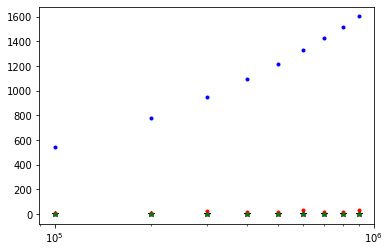

[ 545.45235514  779.10274639  953.01153725 1096.00911825 1219.34907151
 1328.81073828 1427.82381153 1518.6181197  1602.73824983]


In [ ]:
#xi, xf = 600000,600010 #10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(5,6) for i in range(1, 10)])
reality = np.array([log_sum_nonewprimes(x) for x in dx])
assumption = np.array([log_sum_forceoldprimes(x) for x in dx])
ubcaio = np.array([ub_caio(x) for x in dx])
approx3_assumption = np.array([approx3_log_sum_forceoldprimes(x) for x in dx])
plt.plot(dx, reality/ubcaio, 'k*')
plt.plot(dx, assumption/ubcaio, 'r.')
plt.plot(dx, approx3_assumption/ubcaio, 'b.')
plt.plot(dx, ubcaio/ubcaio, 'g.')
plt.xscale('log')
#plt.yscale('log')
plt.show()
print(approx3_assumption/ubcaio)

In [ ]:
print(real_forceoldwprimes/approx1_forceoldprimes)

[0.01537177 0.0133763  0.02456897 0.01189965 0.0116563  0.02226109
 0.01288039 0.01082474 0.0210107 ]


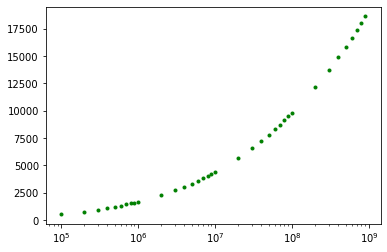

[  545.45235514   779.10274639   953.01153725  1096.00911825
  1219.34907151  1328.81073828  1427.82381153  1518.6181197
  1602.73824983  1681.30534483  2283.54083293  2712.46532965
  3055.35011317  3345.01246442  3597.88249715  3823.52066857
  4028.0433435   4215.62964554  4389.27704917  5677.77551741
  6558.11183134  7244.07456706  7812.99492465  8302.60586549
  8734.44047031  9122.06026802  9474.61053776  9798.57712317
 12141.143241   13690.88716305 14875.70513803 15845.36396756
 16671.42914534 17394.11760945 18038.45241761 18621.1402432 ]


In [ ]:
#xi, xf = 1000, 1100 #500050,500100 # 9*10**6, 9*10**6+5 10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(5,9) for i in range(1, 10)])
#reality = np.array([log_sum_nonewprimes(x) for x in dx])
#assumption = np.array([log_sum_forceoldprimes(x) for x in dx])
#ubstr = np.array([ub_strongest(x) for x in dx])
ubcaio = np.array([ub_caio(x) for x in dx])

#approx1_reality = np.array([approx1_log_sum_nonewprimes(x) for x in dx])
#approx1_assumption = np.array([approx1_log_sum_forceoldprimes(x) for x in dx])
#approx2_assumption = np.array([approx2_log_sum_forceoldprimes(x) for x in dx])
approx3_assumption = np.array([approx3_log_sum_forceoldprimes(x) for x in dx])

#plt.plot(dx, approx3_assumption/reality, 'k*')
#plt.plot(dx, approx3_assumption/assumption, 'r.')
#plt.plot(dx, ubcaio, 'g.')

#plt.plot(dx, approx1_reality, 'k-')
#plt.plot(dx, approx1_assumption, 'r-')
#plt.plot(dx, approx2_assumption, 'b-')
#plt.plot(dx, approx3_assumption, 'b.')

plt.plot(dx, approx3_assumption/ubcaio, 'g.')

#plt.plot(dx, assumption/reality, 'b.')

plt.xscale('log')
#plt.yscale('log')
plt.show()

print(approx3_assumption/ubcaio)

### Testando funcoes que dao a factorization....

In [ ]:
n = 5
bn = int(scp.binom(2*n,n))
print("n = {} --> (2n n) = {}".format(n,bn))
factn = sympy.factorint(bn)
print(factn)

def myfactoriz(n):
  primes = np.array([i for i in sympy.sieve.primerange(2,n+1)])
  myfact = {}
  for p in primes:
    J = int((np.log(2*n)/np.log(p)))
    R = 0
    for j in range(1,J+1):
      R += (np.floor(2*n/p**j)-2*np.floor(n/p**j))
    if R > 0:
      myfact[p] = R
  return myfact
print(myfactoriz(n))


xi, xf = 3,5
dx = np.arange(xi,xf)
reality = np.array([log_sum_nonewprimes(x) for x in dx])
#assumption = np.array([log_sum_forceoldprimes(x) for x in dx])
#plt.plot(dx, reality, 'k.')
#plt.xscale('log')
#plt.show()

n = 5 --> (2n n) = 252
{2: 2, 3: 2, 7: 1}
{2: 2.0, 3: 2.0}


In [ ]:
print([i for i in sympy.sieve.primerange(3, 5)])

[3]


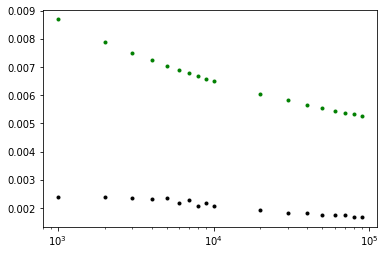

In [ ]:

def myrand(n, k):
  #vals = np.zeros(k//2) #np.random.randint(n, size=k)
  #ones = np.ones(k//2)
  vals = np.random.randint(n, size=k)
  return vals / (2*n)

def excess(n):
  #if n%100 == 0:
  #  print("working on {}".format(n))
  ln = np.log(n)
  k = int(n/ln)
  vals = myrand(n,k)
  avg = np.mean(vals)
  term = 0.
  avgp = np.copy(avg)
  valsp = np.copy(vals)
  for p in range(2,10000):
    avgp = avgp*avg #avg**p
    valsp = valsp*vals
    svalsp = np.sum(valsp)
    term += (svalsp - k*avgp)/(p*k*ln)
  #print("n = {}, k = {} --> {}, {} --> term = {}".format(n,k,vals,avg,term))
  return term

def bound1(n):
  return 0.06/np.log(n)

#xi, xf = 20000, 25000 #500050,500100 # 9*10**6, 9*10**6+5 10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(3,5) for i in range(1, 10)])
yx = np.array([excess(x) for x in dx])
b1x = np.array([bound1(x) for x in dx])

plt.plot(dx, yx, 'k.')
plt.plot(dx, b1x, 'g.')
plt.xscale('log')
#plt.yscale('log')
plt.show()

#for i in range(3,10):
#  excess(i)
  #print("n = {} --> {}".format(i,excess(i)))

In [ ]:
np.sum(np.array([i for i in sympy.sieve.primerange(3,10)]))

15

In [ ]:
a =np.array([i for i in range(1,10,3)])
b1, b2 = a+1, a+2
c = np.sort(np.concatenate([a,b1,b2], axis=0))
print(c)

[1 2 3 4 5 6 7 8 9]


teste simples da agulha...

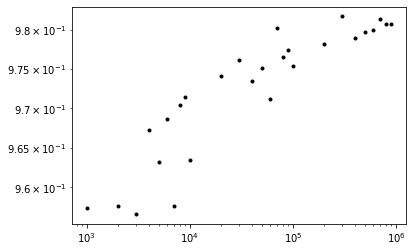

In [ ]:
def sum_terms_uptok(ps,maxk):
  tot = 0.
  for k in range(1,maxk):
    kps = (ps**k)/k
    tot += np.sum(kps)
  return tot


def sum_low(n, maxk):
  lps = np.array([i for i in sympy.sieve.primerange(3, n)])
  lps = lps/(2*n)

  #print("new: {} vs former: {}".format(sum_terms_uptok(nps,10),sum_terms_uptok(lps,10)))
  return sum_terms_uptok(lps,maxk)

def sum_high(n,maxk):
  nps = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
  nps = (2*n - nps)/(2*n)
  return sum_terms_uptok(nps, maxk) 

def lowbound(n):
  return n/(np.log(n))

#or n in range(3,100):
#  sum_low(n)

maxk = 20
#xi, xf = 10, 1000 #20000, 25000 #500050,500100 # 9*10**6, 9*10**6+5 10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
#dx = np.arange(xi,xf)
dx = np.array([i*10**exp for exp in range(3,6) for i in range(1, 10)])

npx = np.array([sum_high(x,maxk) for x in dx])
#lpx = np.array([sum_low(x,maxk) for x in dx])
lbx = np.array([lowbound(x) for x in dx])

plt.plot(dx, npx/lbx/(1-np.log(2)), 'k.')
#plt.plot(dx, lbx, 'r.')

#plt.plot(dx, lpx, 'b.')
#plt.plot(dx, npx/lpx, 'k.')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Testando factorials sem numero par...

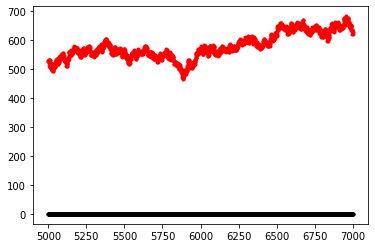

In [ ]:
def log_topfact_odd(n,primes = True,close=False):
  #print(n)
  if n % 2 == 0:
    values = np.array(range(n+1,2*n,2))
  else:
    values = np.array(range(n+2,2*n,2))
  #print(values)
  if not primes:
    new_primes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
    values = np.array(np.setdiff1d(values,new_primes))
  if close:
    new_primes = np.array([i for i in sympy.sieve.primerange(n+1, 2*n)])
    old_primes = np.array([i for i in sympy.sieve.primerange(3, n)])
    old_primes = 2*n - old_primes
    for p in new_primes:
      w = np.argmax(values==p)
      #print("p = {} : v = {} --> {}".format(p,w,values[w]))
      for i in range(w,-1,-1):
        if not values[i] in old_primes:
        #if not sympy.ntheory.isprime(values[i]) and not values[i] in old_primes:
          #print("p = {} : v = {} --> {} : i = {} --> {}".format(p,w,values[w],i,values[i])) 
          values = np.delete(values,i)
          break
        if i == 0:
          for i in range(w,len(values)+1):
            if not values[i] in old_primes:
            #if not sympy.ntheory.isprime(values[i]) and not values[i] in old_primes:
              #print("p = {} : v = {} --> {} : i = {} --> {}".format(p,w,values[w],i,values[i])) 
              values = np.delete(values,i)
              break

  result = np.sum(np.log(values))  
  #print("{} = {}".format(values,result))
  return result
#log_topfact_odd(100)
#log_topfact_odd(100,False)
#log_topfact_odd(100,True,True)

def manual_log_factorial(n):
  values = np.array(range(2,n+1))
  #print(values, np.log(values))
  return np.sum(np.log(values))
# print(log_factorial(10))

def ub_fact(n):
  term1 = np.log(2)*(2*n-np.floor(n/2+0.6))-0.5*np.log(np.pi*n)
  term2 = manual_log_factorial(int(np.ceil(n/2-0.6)))
  term3 = -n  + 1./(8*np.pi) * np.sqrt(2*n) *np.log(2*n)**2 + 1./(8*np.pi) * np.sqrt(n) *np.log(n)**2
  return term1 + term2 + term3

xi, xf = 5000, 7000 #500050,500100 # 9*10**6, 9*10**6+5 10**3, 10**4#,2*10**4 #10**4,2*10**4 #0  
dx = np.arange(xi,xf)
#dx = np.array([i*10**exp for exp in range(3,5) for i in range(1, 10)])
noprimes = np.array([log_topfact_odd(x,False) for x in dx])
closeprimes = np.array([log_topfact_odd(x,True,True) for x in dx])
ubfact = np.array([ub_fact(x) for x in dx])

plt.plot(dx, closeprimes-noprimes, 'k.')
plt.plot(dx, ubfact-noprimes, 'r.')
#plt.plot(dx, closeprimes, 'g.')
#plt.xscale('log')
#plt.yscale('log')
plt.show()
